# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:

**Note: if you are using the Udacity workspace, you *DO NOT* need to re-download these - they can be found in the `/data` folder as noted in the cell below.**

* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dog_images`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [54]:
!pwd

/home/workspace/dog_project


In [22]:
import numpy as np
from glob import glob
from PIL import Image


# load filenames for human and dog images
human_files = np.array(glob("/data/lfw/*/*"))
dog_files = np.array(glob("/data/dog_images/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))



human_folders = np.array(glob("/data/lfw/*"))
dog_folders = np.array(glob("/data/dog_images/train/*"))

There are 13233 total human images.
There are 8351 total dog images.


In [23]:


human_folder_img_counts = [len(np.array(glob(folder+'/*'))) for folder in human_folders]
dog_folder_img_counts = [len(np.array(glob(folder+'/*'))) for folder in dog_folders]
print(len(human_folders))

5749


In [31]:
import numpy as np
humans_with_one_image = np.sum([x for x in human_folder_img_counts if x==1])
humans_with_more_than_one_images = len(human_folders)- humans_with_one_image

print('Humans with one image: {}'.format(humans_with_one_image))
print('Humans with more than one images: {}'.format(humans_with_more_than_one_images))


Humans with one image: 4069
Humans with more than one images: 1680


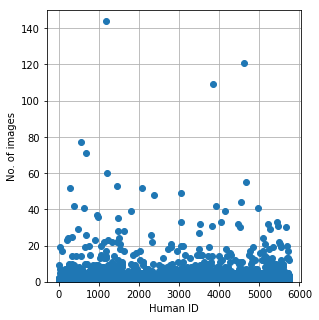

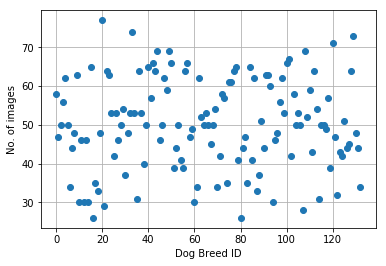

26

In [54]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10, 5))
fig.add_subplot(121)
plt.plot(human_folder_img_counts,'o')
plt.xlabel('Human ID')
plt.ylabel('No. of images')
plt.ylim([0, 150])
plt.grid()
plt.show()

fig.add_subplot(122)
plt.plot(dog_folder_img_counts,'o')
plt.xlabel('Dog Breed ID')
plt.ylabel('No. of images')
plt.grid()
plt.show()

np.min(dog_folder_img_counts)


In [56]:
#!du -hs /data/dog_images/

from PIL import Image

img = Image.open('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')
img.size


(400, 300)

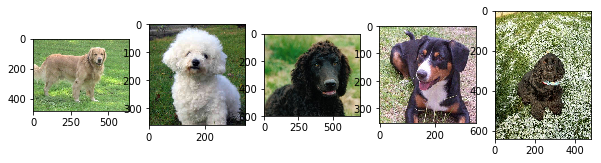

In [82]:
import numpy as np

random_dog_files = np.random.choice(dog_files, 5)

fig = plt.figure(figsize = (10, 5))

for i in range(5):
    fig.add_subplot(1, 5, i+1)
    plt.imshow(Image.open(random_dog_files[i]))

In [57]:
print(human_files.shape)
print(dog_files.shape)
print(human_files[0])
print(dog_files[0])

(13233,)
(8351,)
/data/lfw/Dan_Ackroyd/Dan_Ackroyd_0001.jpg
/data/dog_images/train/103.Mastiff/Mastiff_06833.jpg


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [92]:
#[(human_files[i],i) for i in range(len(human_files)) if 'Jennifer_Aniston' in human_files[i]]

<class 'cv2.CascadeClassifier'>
Number of faces detected: 1


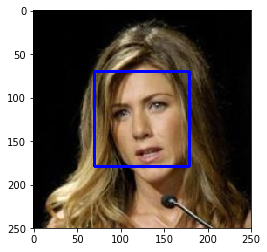

In [93]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

print(type(face_cascade))

# load color (BGR) image
img = cv2.imread(human_files[6876])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
# x, y denote the top-left x, y positions.
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [118]:
# returns "True" if face is detected in image stored at img_path
import torch
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 

* Percentage of the first 100 images in human_files: 0.98
* Percentage of the first 100 images in dog_files: 0.002035684349179739


In [64]:
already_ran = False
if not already_ran:
    from tqdm import tqdm

    human_files_short = human_files[:100]
    dog_files_short = dog_files[:100]

    #-#-# Do NOT modify the code above this line. #-#-#

    ## TODO: Test the performance of the face_detector algorithm 
    ## on the images in human_files_short and dog_files_short.

    are_human_files = []
    are_dog_files = []

    for human_path in tqdm(human_files_short):
        are_human_files.append(face_detector(human_path))

    for dog_path in tqdm(dog_files_short):
        are_dog_files.append(face_detector(dog_path))

    percentage_of_human_files = np.sum(are_human_files)/human_files_short.shape[0]
    percentage_of_dog_files = np.sum(are_dog_files)/dog_files.shape[0]

    print('Percentage of the first 100 images in human_files: {}'.format(percentage_of_human_files))
    print('Percentage of the first 100 images in dog_files: {}'.format(percentage_of_dog_files))

    
# Percentage of the first 100 images in human_files: 0.98
# Percentage of the first 100 images in dog_files: 0.002035684349179739


100%|██████████| 100/100 [00:39<00:00,  2.53it/s]

Percentage of the first 100 images in human_files: 0.98
Percentage of the first 100 images in dog_files: 0.002035684349179739


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [8]:
### (Optional) 
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [119]:
import torchvision.models as models

#models.vgg16?

In [120]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()
#/root/.torch/models/vgg16-397923af.pth

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 96324214.12it/s] 


Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [121]:
from PIL import Image
import torchvision.transforms as transforms

def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    input_image = Image.open(img_path)
    input_tensor = preprocess(input_image)    
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model
    #print(input_tensor.size(), input_batch.size())

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        VGG16.to('cuda')

            
    with torch.no_grad():
        output = VGG16(input_batch)
    # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
    # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
    ans = torch.nn.functional.softmax(output[0], dim=0)
    
    return np.argmax(ans) # predicted class index


VGG16_predict('/data/dog_images/train/001.Affenpinscher/Affenpinscher_00001.jpg')

tensor(252)

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [122]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    predicted_index = VGG16_predict(img_path)
    
    return 151<=predicted_index<=268 # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


* Percentage of human files identified as dogs: 1.0
* Percentage of dog files identified as dogs: 100.0

In [69]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

already_ran = False

if not already_ran:
    percentage_humans = np.sum([dog_detector(img_path) for img_path in human_files_short])/len(human_files_short)*100
    percentage_dogs = np.sum([dog_detector(img_path) for img_path in dog_files_short])/len(dog_files_short)*100

    print('Percentage of human files identified as dogs {}'.format(percentage_humans))
    print('Percentage of dog files identified as dogs {}'.format(percentage_dogs))

Percentage of human files identified as dogs 1.0
Percentage of dog files identified as dogs 100.0


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [14]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [71]:
import os
import torch 
from torchvision import datasets
from torchvision import transforms
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

#resize_size, crop_size = 150, 128
resize_size, crop_size = 256, 224

mean_size = [0.485, 0.456, 0.406]
std_size = [0.229, 0.224, 0.225]

batch_size, num_workers = 4, 2


#https://github.com/pytorch/examples/blob/42e5b996718797e45c46a25c55b031e6768f8440/imagenet/main.py#L89-L101
#https://pytorch.org/docs/stable/torchvision/models.html



data_transforms = {
    'train': 
        transforms.Compose([
        transforms.RandomResizedCrop(crop_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_size, std=std_size),
    ]),

     'valid':
        transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_size, std=std_size),
    ]),

    'test': 
        transforms.Compose([
        transforms.Resize(resize_size),
        transforms.CenterCrop(crop_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean_size, std=std_size),
    ])
    }

data_dir = '/data/dog_images/'

loaders_scratch = {}

image_datasets = {x: datasets.ImageFolder(root=os.path.join(data_dir, x), transform = data_transforms[x])
                  for x in ['train','valid','test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size = batch_size, shuffle=True, num_workers=num_workers)
               for x in ['train','valid','test']}

assert(
    image_datasets['train'].classes == \
    image_datasets['valid'].classes == \
    image_datasets['test'].classes
)                  
class_names = image_datasets['train'].classes

no_classes = len(class_names)

print(f'Number of classes to categorize: {no_classes}')

Number of classes to categorize: 133


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

For final choice of image size, I used the VGG-16 strategy so that we can use it for transfer learning as well. The size of 224x224 is used by many well known algorithms. 

**Training Images**: The images are first resized to 250x250 and then cropped randomly to a size of 224x224. Since, the dog images could be looking either right or left, I performed a horizontal flip in images, so that the training covers both the mirror images as well. 

**Validation and Test Images**: These images do not require a random crop which we intentionally did for training to make the model more robust. I focused only on the center part of the image for validation and testing. So, I just do a center crop of 224x224 after scaling the image to 250x250. Please note that we are only loosing an area of about 19% from the edges. (250^2 - 224^2)/250^2 * 100

All the images in training, validation and test set are normalized to the mean and std below following the ImageNet strategy.

`mean_size = [0.485, 0.456, 0.406]
std_size = [0.229, 0.224, 0.225]`

For the scratch model, we could have very well used `mean = [0.5, 0.5, 0.5]` and `std = [0.5, 0.5, 0.5]` but this doesn't make much difference, and since I want to eventually use transfer learning, I use the 

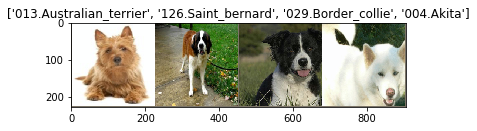

In [74]:
import torchvision

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

#print(len(classes))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
#plt.figure(figsize = (5, 10))
imshow(out, title=[class_names[x] for x in classes])

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [94]:
from torch import nn
import torch.nn.functional as F

class ShallowNet(nn.Module):
    def __init__(self):
        super(ShallowNet, self).__init__()
        self.convolution1 = nn.Conv2d(3, 16, 3, padding=1)   
        self.maxpool1 = nn.MaxPool2d(2, 2)               
        
        self.convolution2 = nn.Conv2d(16, 32, 3, padding=1)  
        self.maxpool2 = nn.MaxPool2d(2, 2)               
        
        self.convolution3 = nn.Conv2d(32, 64, 3, padding=1)  
        self.maxpool3 = nn.MaxPool2d(2, 2)               
                
        self.adapt_avg_pool = nn.AdaptiveAvgPool2d(1)            
        self.fullyconnected = nn.Linear(64, 133)                
  
    def forward(self, x):
        x = self.maxpool1(F.relu(self.convolution1(x)))
        x = self.maxpool2(F.relu(self.convolution2(x)))
        x = self.maxpool3(F.relu(self.convolution3(x)))

        x = self.adapt_avg_pool(x)
        x = x.view(-1, 64 * 1 * 1)
        x = self.fullyconnected(x)            
        return x

In [95]:
class MediumNet(nn.Module):
    def __init__(self):
        super(MediumNet, self).__init__()
        self.convolution1 = nn.Conv2d(3, 16, 3, padding=1)   
        self.maxpool1 = nn.MaxPool2d(2, 2)               
        
        self.convolution2 = nn.Conv2d(16, 32, 3, padding=1)  
        self.maxpool2 = nn.MaxPool2d(2, 2)               
        
        self.convolution3 = nn.Conv2d(32, 64, 3, padding=1)  
        self.maxpool3 = nn.MaxPool2d(2, 2)               
        
        self.convolution4 = nn.Conv2d(64, 128, 3, padding=1) 
        self.maxpool4 = nn.MaxPool2d(2, 2)               
        
        self.adapt_avg_pool = nn.AdaptiveAvgPool2d(1)            
        self.fullyconnected = nn.Linear(128, 133)                
       
  
    def forward(self, x):
        x = self.maxpool1(F.relu(self.convolution1(x)))
        x = self.maxpool2(F.relu(self.convolution2(x)))
        x = self.maxpool3(F.relu(self.convolution3(x)))
        x = self.maxpool4(F.relu(self.convolution4(x)))

        x = self.adapt_avg_pool(x)
        x = x.view(-1, 128 * 1 * 1)
        x = self.fullyconnected(x)            
        return x

In [96]:
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        
        self.convolution1 = nn.Conv2d(3, 16, 3, padding=1)   
        self.maxpool1 = nn.MaxPool2d(2, 2)               
        self.bn1   = nn.BatchNorm2d(16)
        
        self.convolution2 = nn.Conv2d(16, 32, 3, padding=1)  
        self.maxpool2 = nn.MaxPool2d(2, 2)               
        self.bn2   = nn.BatchNorm2d(32)
        
        self.convolution3 = nn.Conv2d(32, 64, 3, padding=1)  
        self.maxpool3 = nn.MaxPool2d(2, 2)               
        self.bn3   = nn.BatchNorm2d(64)
        
        self.convolution4 = nn.Conv2d(64, 128, 3, padding=1) 
        self.maxpool4 = nn.MaxPool2d(2, 2)               
        self.bn4   = nn.BatchNorm2d(128)
        
        self.convolution5 = nn.Conv2d(128, 256, 3, padding=1)
        self.maxpool5 = nn.MaxPool2d(2, 2)              
        self.bn5   = nn.BatchNorm2d(256)
        
        self.adapt_avg_pool = nn.AdaptiveAvgPool2d(1)            
        self.fullyconnected = nn.Linear(256, 133)                
  
    def forward(self, x):
        x = self.batchnorm1(self.maxpool1(F.relu(self.convolution1(x))))
        x = self.batchnorm2(self.maxpool2(F.relu(self.convolution2(x))))
        x = self.batchnorm3(self.maxpool3(F.relu(self.convolution3(x))))
        x = self.batchnorm4(self.maxpool4(F.relu(self.convolution4(x))))
        x = self.batchnorm5(self.maxpool5(F.relu(self.convolution5(x))))
        
        x = self.adapt_avg_pool(x)
        x = x.view(-1, 256 * 1 * 1)
        x = self.fullyconnected(x)        
        
        return x

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

In order to choose the right model, I first start with the simplest model:

1. The first choice is to determine how we are going to increase the number of channels.  The higher the number of channels at downsampling locations, higher is the diversity of high-level attributes. (Example, AlexNet (Krizhevsky, Sutskever, and Hinton 2012), VGG and ResNet). So, I follow similar strategy for the channel number increase. I start with increasing the channel dimension from 3 to 16 and then keep multiplying by the factor of 2. 
2. Next in order to extract the most dominant features among the nearby neighbors, I select max-pooling layers right after the convolution layer. The reason for using a padding of 1 is to keep the image dimension same after max-pooling without lossing any information from the edges. 
3. GlobalAveragePoolingLayer: This layer has shown considerable promise for enforcing correspondences betweenfeature maps and categories [Ref](https://arxiv.org/pdf/1312.4400.pdf). I also tried with dropout layer which makes the model more complex without any additional advantage. 
4. Number of layers: For simplicity, I start with a model which is easier to train having only 3 convolution neural nets. The accurancy of the model is not that good. So, I make the model a bit deeper. Finally, I use make the model even deeper and also introduce batch normalization to improve the speed, accuracy and stability of the model (since the network is larger it is otherwise too slow and unstable).



### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [97]:
import torch.optim as optim


### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer

model_scratch = ShallowNet()
model_params = model_scratch.parameters()

optimizer_scratch = optim.Adam(
    model_params,
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
)


In [103]:
model_scratch

DeepNet(
  (convolution1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(128, eps=1e

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [7]:
from workspace_utils import active_session
import collections
import numpy as np


from datetime import datetime

    
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss

    #model_name = model._get_name()
    #print('Starting training Model: {}'.format(model_name))
    
    valid_loss_min = np.Inf 

    loss_dict = collections.defaultdict(list)

    # folder for saving model files
    if not os.path.exists(save_path.split('/')[0]):
                os.makedirs(save_path.split('/')[0])
        
    for epoch in range(1, n_epochs+1):

        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        train_correct = 0.0
        valid_correct = 0.0

        train_total = 0.0
        valid_total = 0.0

        ###################
        # train the model #
        ###################
        model.train()

        start_train = datetime.now()

        #running_train_loss = 0.0

        for batch_idx, (data, target) in enumerate(loaders['train']):
            
            #if batch_idx%1000 == 0:
            #    print(f'Epoch: {epoch}, Batch: {batch_idx}')
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))

            #initialize all the gradients with zero.

            optimizer.zero_grad()

            #forward + backword + optimize
            train_output = model(data)
            loss = criterion(train_output, target)
            loss.backward()
            optimizer.step()

            # update average test loss 
            #train_loss += train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            train_loss += loss.data*data.size(0)
            # convert output probabilities to predicted class
            train_pred = train_output.data.max(1, keepdim=True)[1]
            # compare predictions to true label
            train_correct += np.sum(np.squeeze(train_pred.eq(target.data.view_as(train_pred))).cpu().numpy())
            train_total += data.size(0)

        stop_train = datetime.now()
        
        ## TODO: save the model if validation loss has decreased

        ######################    
        # validate the model #
        ######################
        model.eval()
        
        start_valid = datetime.now()
        
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss

            valid_output = model(data)
            loss = criterion(valid_output, target)            
#                valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            valid_loss += loss.data*data.size(0)
            valid_pred = valid_output.data.max(1, keepdim=True)[1]

            valid_correct += np.sum(np.squeeze(valid_pred.eq(target.data.view_as(valid_pred))).cpu().numpy())
            valid_total += data.size(0)

        stop_valid = datetime.now()

        train_acc, valid_acc = train_correct/train_total*100.0, valid_correct/valid_total*100.0
        train_loss_per_instance, valid_loss_per_instance = train_loss/train_total, valid_loss/valid_total
        print('Epoch: {} Training Loss: {:.6f}, Validation Loss: {:.6f}, \
               Train acc. {:.2f}:, Valid acc. {:.2f}'.format(epoch, \
               train_loss_per_instance, valid_loss_per_instance, \
                train_acc, valid_acc))

        loss_dict['train_loss_per_instance'].append(train_loss_per_instance)
        loss_dict['valid_loss_per_instance'].append(valid_loss_per_instance)
        loss_dict['train_acc'].append(train_acc)
        loss_dict['valid_acc'].append(valid_acc)
        
        loss_dict['train_time'].append([epoch, stop_train-start_train])
        loss_dict['valid_time'].append([epoch, stop_valid-start_valid])
        
        ## TODO: save the model if validation loss has decreased
        
        prefix_path = save_path.split('.')[0]        
        
        if valid_loss<=valid_loss_min:
            
            save_path_new = prefix_path+'_val_loss_decreased.pt'
            torch.save(model.state_dict(), save_path_new)

        if epoch%5==0:
            save_path_new = prefix_path+'_epoch'+str(epoch)+'.pt'
            print('Saving model at epoch: {}, filename: {}'.format(epoch, save_path_new))
            torch.save(model.state_dict(), save_path_new)
            print('Model saved!')

        valid_loss_min = valid_loss
        
    return model, loss_dict



In [9]:
import torch.optim as optim
torch.cuda.empty_cache()

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer

model_scratch = ShallowNet()
#model_scratch = MediumNet()
use_cuda = torch.cuda.is_available()

if use_cuda:
    model_scratch.cuda()
    print('moving to cuda')

model_params = model_scratch.parameters()

optimizer_scratch = optim.Adam(
    model_params,
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
)

moving to cuda


In [10]:
with active_session():
    # train the model
    model_scratch, loss_dict = train(20, dataloaders, model_scratch, optimizer_scratch, 
                          criterion_scratch, use_cuda, 'ShallowNet/model_scratch.pt')

Epoch: 1 Training Loss: 4.859273, Validation Loss: 4.774646,                Train acc. 1.30:, Valid acc. 1.68
Epoch: 2 Training Loss: 4.722713, Validation Loss: 4.680795,                Train acc. 2.19:, Valid acc. 2.87
Epoch: 3 Training Loss: 4.631477, Validation Loss: 4.620660,                Train acc. 3.13:, Valid acc. 3.59
Epoch: 4 Training Loss: 4.587457, Validation Loss: 4.583181,                Train acc. 3.49:, Valid acc. 3.83
Epoch: 5 Training Loss: 4.550487, Validation Loss: 4.535692,                Train acc. 3.79:, Valid acc. 5.15
Saving model at epoch: 5, filename: ShallowNet/model_scratch_epoch5.pt
Model saved!
Epoch: 6 Training Loss: 4.493820, Validation Loss: 4.504888,                Train acc. 4.55:, Valid acc. 4.19
Epoch: 7 Training Loss: 4.451573, Validation Loss: 4.488433,                Train acc. 5.07:, Valid acc. 5.15
Epoch: 8 Training Loss: 4.405447, Validation Loss: 4.401654,                Train acc. 5.60:, Valid acc. 5.03
Epoch: 9 Training Loss: 4.358860, Va

In [16]:
!ls ShallowNet

Loss_till_epoch_20.pkl.pkl  model_scratch_epoch25.pt
model_scratch_epoch10.pt    model_scratch_epoch30.pt
model_scratch_epoch15.pt    model_scratch_epoch5.pt
model_scratch_epoch20.pt    model_scratch_val_loss_decreased.pt


In [17]:
import pickle

loss_file = 'ShallowNet/Loss_till_epoch_20.pkl'

if not os.path.exists(loss_file):
    f = open(loss_file,"wb")
    pickle.dump(loss_dict,f)
    f.close()



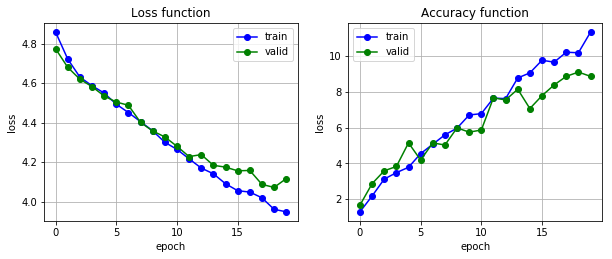

In [20]:
import matplotlib.pyplot as plt

loss_file = 'ShallowNet/Loss_till_epoch_20.pkl'

with open(loss_file, 'rb') as handle:
    loss_dict_loaded = pickle.load(handle)
    
    train_loss_per_instance_till_epoch_20 = [x.cpu().numpy() for x in loss_dict_loaded['train_loss_per_instance']]
    valid_loss_per_instance_till_epoch_20 = [x.cpu().numpy() for x in loss_dict_loaded['valid_loss_per_instance']]

    fig = plt.figure(figsize = (10, 8))
    
    fig.add_subplot(2, 2, 1)
    plt.plot(train_loss_per_instance_till_epoch_20, '-ob', label = 'train')
    plt.plot(valid_loss_per_instance_till_epoch_20,'-og', label = 'valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.title('Loss function')

    fig.add_subplot(2, 2, 2)
    plt.plot(loss_dict_loaded['train_acc'], '-ob', label = 'train')
    plt.plot(loss_dict_loaded['valid_acc'],'-og', label = 'valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()    
    plt.title('Accuracy function')


In [22]:
import torch.optim as optim

torch.cuda.empty_cache()

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer

#model_scratch = ShallowNet()
model_scratch = MediumNet()

if use_cuda:
    model_scratch.cuda()
    print('moving to cuda')

model_params = model_scratch.parameters()

optimizer_scratch = optim.Adam(
    model_params,
    lr=0.001,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
)

moving to cuda


In [23]:
with active_session():
    # train the model
    model_scratch, loss_dict = train(20, dataloaders, model_scratch, optimizer_scratch, 
                          criterion_scratch, use_cuda, 'MediumNet/model_scratch.pt')




Epoch: 1 Training Loss: 4.871406, Validation Loss: 4.807890,                Train acc. 0.94:, Valid acc. 1.56
Epoch: 2 Training Loss: 4.740020, Validation Loss: 4.647314,                Train acc. 2.19:, Valid acc. 2.87
Epoch: 3 Training Loss: 4.629879, Validation Loss: 4.562338,                Train acc. 2.78:, Valid acc. 3.71
Epoch: 4 Training Loss: 4.523617, Validation Loss: 4.454714,                Train acc. 3.80:, Valid acc. 4.55
Epoch: 5 Training Loss: 4.409393, Validation Loss: 4.337151,                Train acc. 5.15:, Valid acc. 5.27
Saving model at epoch: 5, filename: MediumNet/model_scratch_epoch5.pt
Model saved!
Epoch: 6 Training Loss: 4.292978, Validation Loss: 4.208595,                Train acc. 5.85:, Valid acc. 5.87
Epoch: 7 Training Loss: 4.196930, Validation Loss: 4.148162,                Train acc. 7.14:, Valid acc. 8.98
Epoch: 8 Training Loss: 4.120950, Validation Loss: 4.053166,                Train acc. 8.43:, Valid acc. 8.62
Epoch: 9 Training Loss: 4.042178, Val

In [29]:
import pickle

loss_file = 'MediumNet/Loss_till_epoch_20.pkl'

if not os.path.exists(loss_file):
    f = open(loss_file,"wb")
    pickle.dump(loss_dict,f)
    f.close()


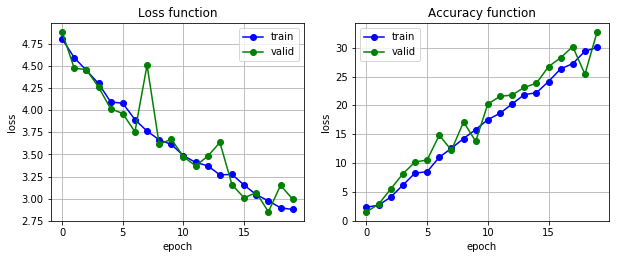

In [25]:
loss_file = 'MediumNet/Loss_till_epoch_20.pkl'

with open(loss_file, 'rb') as handle:
    loss_dict_loaded = pickle.load(handle)
    
    train_loss_per_instance_till_epoch_20 = [x.cpu().numpy() for x in loss_dict_loaded['train_loss_per_instance']]
    valid_loss_per_instance_till_epoch_20 = [x.cpu().numpy() for x in loss_dict_loaded['valid_loss_per_instance']]

    fig = plt.figure(figsize = (10, 8))
    
    fig.add_subplot(2, 2, 1)
    plt.plot(train_loss_per_instance_till_epoch_20, '-ob', label = 'train')
    plt.plot(valid_loss_per_instance_till_epoch_20,'-og', label = 'valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.title('Loss function')

    fig.add_subplot(2, 2, 2)
    plt.plot(loss_dict_loaded['train_acc'], '-ob', label = 'train')
    plt.plot(loss_dict_loaded['valid_acc'],'-og', label = 'valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()    
    plt.title('Accuracy function')


In [101]:
import torch.optim as optim

torch.cuda.empty_cache()

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

use_cuda = torch.cuda.is_available()
### TODO: select optimizer

#model_scratch = ShallowNet()
model_scratch = DeepNet()

if use_cuda:
    model_scratch.cuda()
    print('moving to cuda')

model_params = model_scratch.parameters()

optimizer_scratch = optim.Adam(
    model_params,
    lr=0.01,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False,
)

moving to cuda


In [102]:
model_scratch

DeepNet(
  (convolution1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convolution4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (bn4): BatchNorm2d(128, eps=1e

In [81]:

with active_session():
    # train the model
    model_scratch, loss_dict = train(20, dataloaders, model_scratch, optimizer_scratch, 
                          criterion_scratch, use_cuda, 'DeepNet/model_scratch.pt')


Epoch: 1 Training Loss: 4.804806, Validation Loss: 4.881927,                Train acc. 2.34:, Valid acc. 1.56
Epoch: 2 Training Loss: 4.593350, Validation Loss: 4.473632,                Train acc. 2.72:, Valid acc. 2.87
Epoch: 3 Training Loss: 4.450154, Validation Loss: 4.458652,                Train acc. 4.10:, Valid acc. 5.51
Epoch: 4 Training Loss: 4.302367, Validation Loss: 4.261641,                Train acc. 6.18:, Valid acc. 8.14
Epoch: 5 Training Loss: 4.093308, Validation Loss: 4.016527,                Train acc. 8.26:, Valid acc. 10.18
Saving model at epoch: 5, filename: DeepNet/model_scratch_epoch5.pt
Model saved!
Epoch: 6 Training Loss: 4.078320, Validation Loss: 3.962332,                Train acc. 8.50:, Valid acc. 10.54
Epoch: 7 Training Loss: 3.893896, Validation Loss: 3.755588,                Train acc. 11.02:, Valid acc. 14.85
Epoch: 8 Training Loss: 3.763810, Validation Loss: 4.509345,                Train acc. 12.56:, Valid acc. 12.22
Epoch: 9 Training Loss: 3.665819,

In [85]:
import pickle

loss_file = 'DeepNet/Loss_till_epoch_20.pkl'

if not os.path.exists(loss_file):
    f = open(loss_file,"wb")
    pickle.dump(loss_dict,f)
    f.close()


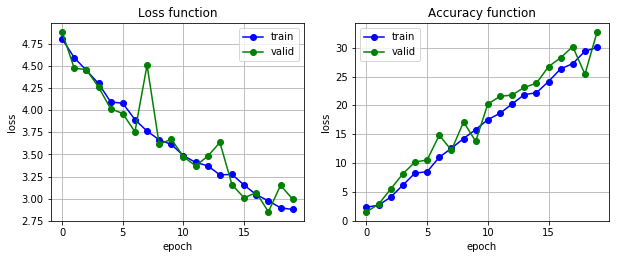

In [86]:
loss_file = 'DeepNet/Loss_till_epoch_20.pkl'

with open(loss_file, 'rb') as handle:
    loss_dict_loaded = pickle.load(handle)
    
    train_loss_per_instance_till_epoch_20 = [x.cpu().numpy() for x in loss_dict_loaded['train_loss_per_instance']]
    valid_loss_per_instance_till_epoch_20 = [x.cpu().numpy() for x in loss_dict_loaded['valid_loss_per_instance']]

    fig = plt.figure(figsize = (10, 8))
    
    fig.add_subplot(2, 2, 1)
    plt.plot(train_loss_per_instance_till_epoch_20, '-ob', label = 'train')
    plt.plot(valid_loss_per_instance_till_epoch_20,'-og', label = 'valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()
    plt.title('Loss function')

    fig.add_subplot(2, 2, 2)
    plt.plot(loss_dict_loaded['train_acc'], '-ob', label = 'train')
    plt.plot(loss_dict_loaded['valid_acc'],'-og', label = 'valid')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.grid()    
    plt.title('Accuracy function')

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


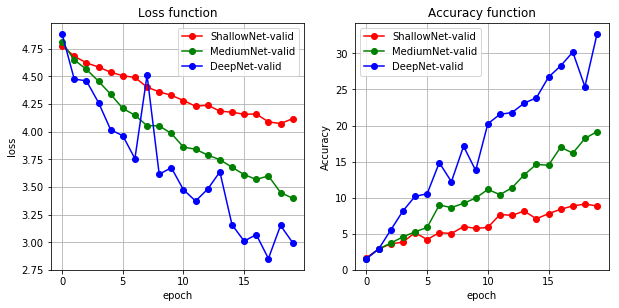

In [78]:
# Comparison of the loss function and accuracy of 3 models


loss_folders = ['ShallowNet', 'MediumNet', 'DeepNet']
xcolors = 'rgb'
fig = plt.figure(figsize = (10, 10))

for i, loss_folder in enumerate(loss_folders):
    with open(os.path.join(loss_folder, 'Loss_till_epoch_20.pkl'), 'rb') as handle:
        loss_dict_loaded = pickle.load(handle)

        train_loss_per_instance_till_epoch_20 = [x.cpu().numpy() for x in loss_dict_loaded['train_loss_per_instance']]
        valid_loss_per_instance_till_epoch_20 = [x.cpu().numpy() for x in loss_dict_loaded['valid_loss_per_instance']]


        fig.add_subplot(2, 2, 1)
        #plt.plot(train_loss_per_instance_till_epoch_20, '-o'+xcolor[i], label = 'train')
        plt.plot(valid_loss_per_instance_till_epoch_20,'-o'+xcolor[i], label = loss_folder+'-valid')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.grid()
        plt.title('Loss function')

        fig.add_subplot(2, 2, 2)
        #plt.plot(loss_dict_loaded['train_acc'], '-o'+xcolor[i], label = 'train')
        plt.plot(loss_dict_loaded['valid_acc'],'-o'+xcolor[i], label = loss_folder+'-valid')
        plt.xlabel('epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid()    
        plt.title('Accuracy function')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [108]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))


In [40]:
model_scratch = DeepNet()
model_scratch.cuda()
model_scratch.load_state_dict(torch.load('DeepNet/model_scratch_epoch20.pt'))
# call test function    
test(dataloaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.835753


Test Accuracy: 31% (264/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [110]:
## TODO: Specify data loaders

# Reference utilized
#https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
    
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(250),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
     'test': transforms.Compose([
        transforms.Resize(250),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/data/dog_images/'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'valid','test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

loaders_transfer = dataloaders


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [105]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

model_transfer = models.resnet18(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(num_ftrs, len(class_names))

if use_cuda:
    model_transfer = model_transfer.cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.torch/models/resnet18-5c106cde.pth
100%|██████████| 46827520/46827520 [00:00<00:00, 88580629.07it/s]


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 

* Resnet18 model has performed well for the image net problems. Further, the example given in [Ref](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html), shows that model performs quite well with transfer learning on the ants vs. bees dataset. So, I thought to give it a try. 

* Unlike the reference where a binary classification is done, we need to do classification for the dog-breeds (133), so I change the number of output features to 133 (i.e. number of output classes). 
* Finally, for simplicity of training, I just retrain the last layer as suggested here [ConvNet as fixed feature extractor
](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html). 

* This gives me good enough accuracy to meet the project goals. 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [113]:
criterion_transfer = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized

optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_transfer, step_size=7, gamma=0.1)


### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [49]:
# train the model
n_epochs = 20


model_transfer, loss_dict  =  train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'transfer_learning/model_transfer.pt')


Epoch: 1 Training Loss: 3.850227, Validation Loss: 1.593368,                Train acc. 16.90:, Valid acc. 54.49
Epoch: 2 Training Loss: 2.623500, Validation Loss: 1.006625,                Train acc. 37.81:, Valid acc. 72.22
Epoch: 3 Training Loss: 2.246910, Validation Loss: 0.785758,                Train acc. 44.79:, Valid acc. 75.69
Epoch: 4 Training Loss: 2.027091, Validation Loss: 0.750917,                Train acc. 49.45:, Valid acc. 75.93
Epoch: 5 Training Loss: 1.919556, Validation Loss: 0.672313,                Train acc. 51.26:, Valid acc. 77.96
Saving model at epoch: 5, filename: transfer_learning/model_transfer_epoch5.pt
Model saved!
Epoch: 6 Training Loss: 1.857921, Validation Loss: 0.669428,                Train acc. 52.10:, Valid acc. 77.49
Epoch: 7 Training Loss: 1.767623, Validation Loss: 0.619355,                Train acc. 54.43:, Valid acc. 78.80
Epoch: 8 Training Loss: 1.710147, Validation Loss: 0.629497,                Train acc. 55.93:, Valid acc. 79.76
Epoch: 9 Tra

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [114]:
# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('transfer_learning/model_transfer_epoch20.pt'))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.672146


Test Accuracy: 80% (676/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [115]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in class_names]

def predict_breed_transfer(img_path, model, class_names, use_cuda):
    # load the image and return the predicted breed
    

    preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    input_image = Image.open(img_path)
    input_tensor = preprocess(input_image)    
    input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

    if torch.cuda.is_available():
        input_batch = input_batch.to('cuda')
        model = model.cuda()
        
    with torch.no_grad():
        output = model(input_batch)
        _, prediction = torch.max(output, 1)

    prediction = prediction[0].cpu().numpy()
    
        
    return class_names[prediction]


---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [116]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    message = None
    if face_detector(img_path):
        message = 'Hey buddy! Did you know you look like a '
    elif dog_detector(img_path):
        message = 'Hi Puppy! Your breed is '
    if message is not None:
        breed = predict_breed_transfer(img_path, model_transfer, class_names, use_cuda)
        message += breed + '!'
    else:
        message = 'The image is neither of a human or a dog!'
    
    plt.figure()
    plt.imshow(Image.open(img_path))
    plt.title(message)

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

* Output is worse. Out of 4 dog images, 3 were classified correctly, but 1 was incorrectly classified. But, the sample size (just 4 dog images) is pretty small, so it is just statistically not relevant to say that this output is worse.

* For the incorrect classification, the classifier identified a Pug as bulldog. Since, the pug and bulldog are look alike, the classifier is unable to differentiate between them. Upon further probe into dataset, I found that we do not have any Pug images. So, the classifier has no way to identify a Pug.

## Possible Improvements

* We need to train our algorithm to more breeds of dogs for it to be able to differentiate betweeen theem.
* We need to let the model train for longer. For all the networks trained in this project, the loss function was still decreasing and hence we can improve on the accuracy. However, due to time constraints, I just met the project goals.
* The DeepNet is not really very deep. It still has only few layers compared to the well known classifiers. We can have a more complex architecture with better accuracy.
* I only did a manual hyperparameter search. Hence, it is not optimal. For optimal hyperparameters, we can use AWS Sagemaker or some other services.
* The time taken by the classifer was large even though the network wasn't that deep. I couldn't use a batch size larger than 20 as there was memory error due to shared resources. We can ideally train the network on better hardware.



images/angelina.jpg
images/brad_pitt.jpg
images/Dwayne-Johnson.jpg
images/Labrador.jpg
images/Jack_Russell_Terrier.jpg
images/Pug.jpg
images/german_shephard.jpg


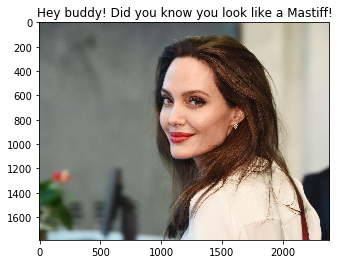

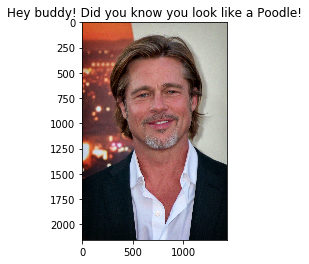

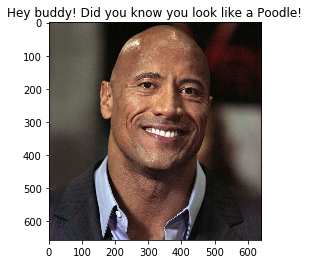

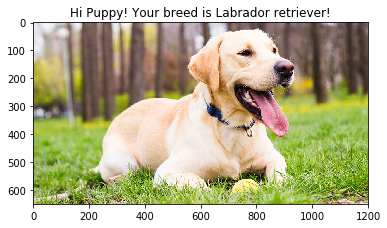

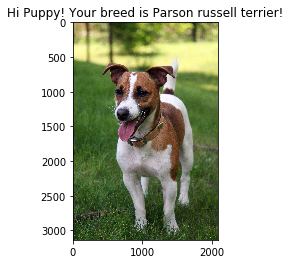

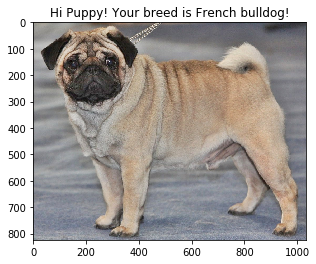

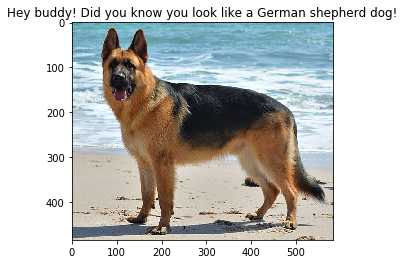

In [123]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

human_images = ['angelina.jpg', 'brad_pitt.jpg', 'Dwayne-Johnson.jpg']
dog_images = ['Labrador.jpg', 'Jack_Russell_Terrier.jpg','Pug.jpg','german_shephard.jpg']

## suggested code, below
for file in human_images:
    print('images/'+file)
    run_app('images/'+file)
    
for file in dog_images:
    print('images/'+file)
    run_app('images/'+file)    

In [77]:
#!pip install torchviz


    100% |████████████████████████████████| 51kB 3.4MB/s ta 0:00:011
  Running setup.py bdist_wheel for torchviz ... done
  Stored in directory: /root/.cache/pip/wheels/2a/c2/c5/b8b4d0f7992c735f6db5bfa3c5f354cf36502037ca2b585667
Successfully built torchviz
